In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import binom

In [23]:
sgr_data = pd.read_csv(r'C:/Users/olubl/OneDrive/College/Data+/DPS-Planning/sgr_htype_reg.csv')
sgr_data = sgr_data.dropna()
sgr_data = sgr_data[['housing_type','region','du_est_final','sgr_dps_avg_k12']]
sgr_data['sgr_dps_avg_k12'] = sgr_data['sgr_dps_avg_k12'].round(4)
sgr_data['region'].unique()

array(['Central', 'East', 'North', 'Southeast', 'Southwest'], dtype=object)

In [24]:
#read in shapefile to get geometries for regions
regions=gpd.read_file(r'C:/Users/olubl/OneDrive/College/Data+/DPS-Planning/DPS_Regions.zip')
regions=regions[['ShortName','geometry']]
regions.columns=['region','geometry']
regions['region'].unique()

array(['Riverside', 'Southern School of Energy and Sustainability',
       'Northern', 'Jordan', 'Hillside'], dtype=object)

In [25]:
#rename schools to regions in order to merge dfs
regions['region'] = regions['region'].replace({
    'Jordan': 'Southwest',
    'Southern School of Energy and Sustainability': 'East',
    'Northern': 'North',
    'Riverside': 'Central',
    'Hillside': 'Southeast'
})
regions

,region,geometry
0,Central,"POLYGON ((-8.78e+06 4.3e+06, -8.78e+06 4.3e+06..."
1,East,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06..."
2,North,"POLYGON ((-8.79e+06 4.33e+06, -8.78e+06 4.33e+..."
3,Southwest,"POLYGON ((-8.79e+06 4.3e+06, -8.79e+06 4.3e+06..."
4,Southeast,"POLYGON ((-8.78e+06 4.3e+06, -8.78e+06 4.3e+06..."


In [26]:
sgr_data = sgr_data.merge(regions, on='region')

In [27]:
#use dictionaries to break down dataframe by region/housing type
sgr_reg = {
    reg:sgr_data[sgr_data['region']==reg]
    for reg in sgr_data['region'].unique()
}
sgr_housing_type = {
    parcel:sgr_data[sgr_data['housing_type']==parcel]
    for parcel in sgr_data['housing_type'].unique()
}

In [28]:
detach = sgr_housing_type['sf_detach']
detach = gpd.GeoDataFrame(detach, geometry = 'geometry')
detach

,housing_type,region,du_est_final,sgr_dps_avg_k12,geometry
7,sf_detach,Central,8977,0.2622,"POLYGON ((-8.78e+06 4.3e+06, -8.78e+06 4.3e+06..."
16,sf_detach,East,18892,0.2184,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06..."
25,sf_detach,North,19970,0.2687,"POLYGON ((-8.79e+06 4.33e+06, -8.78e+06 4.33e+..."
34,sf_detach,Southeast,12906,0.2150,"POLYGON ((-8.78e+06 4.3e+06, -8.78e+06 4.3e+06..."
43,sf_detach,Southwest,18061,0.2364,"POLYGON ((-8.79e+06 4.3e+06, -8.79e+06 4.3e+06..."


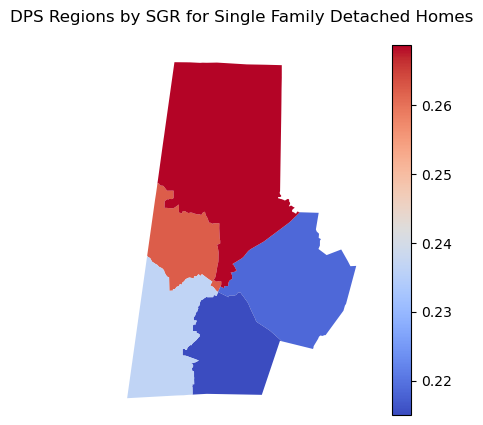

In [29]:
#now we plot the SGR by region
column = 'sgr_dps_avg_k12'
vmin = detach[column].min
vmax = detach[column].max

detach.plot(
    column = column,
    cmap = 'coolwarm',
    legend = True,
)
plt.title('DPS Regions by SGR for Single Family Detached Homes')
plt.axis('off')
plt.show()

In [30]:
#sgr for whole county
sgr_total = np.average(detach['sgr_dps_avg_k12'],weights=detach['du_est_final'])
print(sgr_total)

0.2397042306423369


In [31]:
#assuming SGR is obtained binomially with p=sgr_total across the county, prob of obtaining such a result or more extreme

#k,n,p = detach.loc[7,'parcel_ct']*detach.loc[7,'sgr_dps_avg_k12'],detach.loc[7,'parcel_ct'], sgr_total
#print(binom.cdf(k,n,p))
for i,region in enumerate(detach['region']):
    k = detach.reset_index().loc[i,'du_est_final']*detach.reset_index().loc[i,'sgr_dps_avg_k12']
    n = detach.reset_index().loc[i,'du_est_final']
    p = sgr_total
    if binom.cdf(k,n,p)<0.5:
        print(binom.cdf(k,n,p)) 
    else:
        print(1-binom.cdf(k,n,p))
    
#furthermore, we conclude that sgr differs significantly by region

3.9612547308998103e-07
2.2243120175220132e-12
0.0
1.3684760089871895e-11
0.1486079532713641


In [32]:
#calculate total sgr for each region and convert to a new df
sgr_by_region = []
for region in sgr_data['region'].unique():
    sgr = np.average(sgr_reg[region]['sgr_dps_avg_k12'], weights=sgr_reg[region]['du_est_final'])
    sgr_by_region.append({'region':region,'sgr':sgr})

sgr_by_region = pd.DataFrame(sgr_by_region)
print(sgr_by_region)
#now we have a df showing the sgr by region for all new developments

      region       sgr
0    Central  0.201614
1       East  0.211576
2      North  0.262966
3  Southeast  0.161409
4  Southwest  0.189659


In [33]:
sgr_by_house_type = []
for housing_type in sgr_data['housing_type'].unique():
    sgr = np.average(sgr_housing_type[housing_type]['sgr_dps_avg_k12'], weights=sgr_housing_type[housing_type]['du_est_final'])
    sgr_by_house_type.append({'housing_type':housing_type,'sgr':sgr})

sgr_by_house_type = pd.DataFrame(sgr_by_house_type)

sgr_by_house_type['housing_type'] =\
sgr_by_house_type['housing_type'].replace({'age_restrict':'Age Restricted Development',
                                            'sf_detach':'Single Family Detached',
                                            'sf_attach':'Single Family Attached',
                                            'mf_apt':'Multifamily Apartment',
                                           'condo':'Condo',
                                           'temp':'Temporary Housing (shelter)',
                                           'hud':'Housing Urban Development',
                                           'du_tri':'Duplex and Triplex',
                                           'manuf':'Manufactured Housing (trailers)'
                                          })
print(sgr_by_house_type.round(3))

                      housing_type    sgr
0       Age Restricted Development  0.004
1                            Condo  0.086
2               Duplex and Triplex  0.233
3        Housing Urban Development  0.619
4  Manufactured Housing (trailers)  0.448
5            Multifamily Apartment  0.188
6           Single Family Attached  0.072
7           Single Family Detached  0.240
8      Temporary Housing (shelter)  0.107


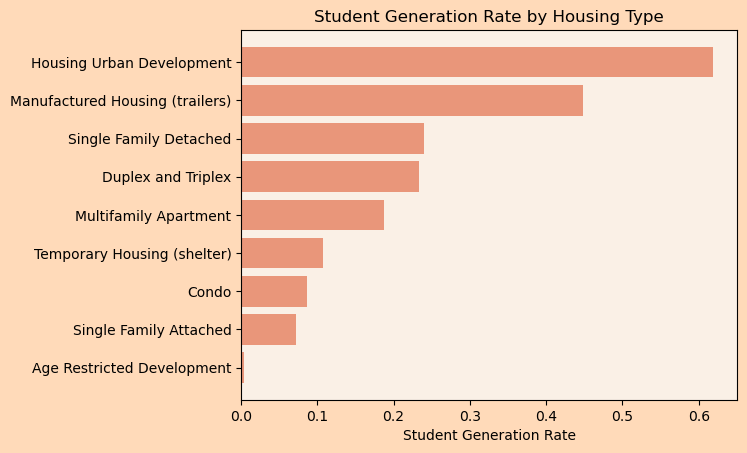

In [34]:
sgr_by_house_type = sgr_by_house_type.sort_values('sgr')
fig,ax = plt.subplots(facecolor = 'peachpuff')

ax.barh(sgr_by_house_type['housing_type'],sgr_by_house_type['sgr'],color = 'darksalmon')
ax.set_title('Student Generation Rate by Housing Type')
ax.set_xlabel('Student Generation Rate')
ax.set_facecolor('linen')
plt.show()

In [35]:
#pie chart to show what the new developments are
parcel_by_housing_type = []
for house in sgr_data['housing_type'].unique():
    parcel_total = sum(sgr_data[sgr_data['housing_type']==house]['du_est_final'])
    if house == 'sf_attach' or house == 'sf_detach':
        print(house,parcel_total)
print('other',sum(sgr_data[sgr_data['housing_type']==])

SyntaxError: invalid syntax (1961865737.py, line 7)

In [ ]:
sgr_data.head()

In [ ]:
#load in developments data and merge
#filtered3 = gpd.read_file(r'C:/Users/olubl/OneDrive/College/Data+/DPS-Planning/filtered3_with_school.geojson')
#filtered3.head()